### This notebook is a demonstration of how to use our topic model to:

1. Obtain topics
2. Visualize topic transition heat maps
3. Reproduce topic transition chain/graphs



In [4]:
# import dependencies
import sys

import matplotlib
import matplotlib.pyplot as plt
import random
import torch
from torch import nn, optim
from torch.autograd import Function
import numpy as np
import os
import pickle
import data_analysis_utils
from data_analysis_utils import (prepare_text_for_lda, build_reduced_glove_dict,
convert_token_2_ids, text_to_topic, compute_topic_transition_matrix, filtere_off_unk_topics)
from collections import Counter
import dae_model
from dae_model import DictionaryAutoencoder
import time

#### GPU required

In [5]:
device = 'cuda:0'

#### Fix random seed for python, numpy and torch to ensure reproducibility 

In [6]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

#### Load pretrained topic model and stored storium data

In [7]:
final_data_path = './final_pooled_dev'



# pretrained model (the model is trained on pooled data of entries and challenges)
with open(os.path.join(final_data_path, 'no_filter_train_30_10.pt'), 'rb') as f:
    model = torch.load(f, map_location=device)  # put the model on specified device
model.to(device)  # simply load without parallelism
model.device = device
model.eval()

# read the dictionary of entries and challenges pooled by story and then by worlds
with open( os.path.join(final_data_path, 'text_by_story_world_dict.pkl'), 'rb') as f:
    text_by_story_world_dict = pickle.load(f)
    

# read the saved vocab (word embedding + word2id dict) used by the topic model
embedding_matrix_np = np.load(os.path.join(final_data_path, 'embedding_matrix.npy'))
with open(os.path.join(final_data_path, 'word2id_dict.pkl'), 'rb') as f:
    word2id_dict = pickle.load(f)


    
# load the previously annotated world labels (and keep track of the unknown topics' id)
with open( os.path.join(final_data_path, 'topics.txt'), 'r') as f:
    lines = f.readlines()
topics_summarized = []
idx_filter_off = []
for idx, line in enumerate( lines ):
    line_split = line.strip().split(': ')[1]
    topics_summarized.append(line_split)


        
# load the previously inferred topic transition matrices in each world
config = 'role'
with open(os.path.join( final_data_path, f'topic_transition_matrix_by_world_dict_{config}.pkl'), 'rb') as f:
    topic_transition_matrix_by_world_dict = pickle.load(f)

# count the number of stories in each world
world_counter = Counter()
for world, stories in text_by_story_world_dict.items():
    world_counter.update({world: len(stories)})
    
print(f'Finished loading the model and text (from {len(text_by_story_world_dict)} worlds in total)')


Finished loading the model and text (from 59 worlds in total)


### Visualize the topics

In [10]:
with open( os.path.join( final_data_path, 'to_be_removed.pkl' ), 'rb' ) as f:
    to_be_removed = pickle.load(f) # this is a list of words to be removed from interpreting topc 

model.rank_vocab_for_topics(word_embedding_matrix=embedding_matrix_np, to_be_removed=to_be_removed)

topic 0 : melodramatic, reenactment, film, thriller, backstory, narration, melodrama, storyline, subplots, subplot
topic 1 : delicious, d'oeuvres, lunch, brunch, dinner, appetizer, gourmet, buffet, meal, breakfast
topic 2 : beneficiary, liabilities, percentage, average, cent, million, income, total, billion, percent
topic 3 : freighter, crewmembers, cockpit, airship, propulsion, spaceship, vessel, aboard, aircraft, spacecraft
topic 4 : chlorine, gaseous, isotope, temperature, hydrogen, contaminant, runoff, spectrometer, particulate, biological
topic 5 : thine, fealty, uphold, valor, infantry, dominion, nobility, sword, valour, righteousness
topic 6 : shrimp, sauce, roast, truffle, avocado, cheese, chicken, garlic, beef, salad
topic 7 : melodic, likeable, crunchy, tasty, witty, wonderfully, delicious, flavorful, personable, catchy
topic 8 : unconvincing, boisterous, overwrought, dissonant, melodramatic, strident, bombastic, cacophonous, overblown, raucous
topic 9 : aunt, niece, widower,

### Visualize different "worlds"

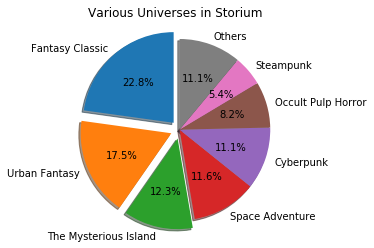

In [11]:
labels = []
sizes = []
size_remaining = 0

for idx, world_tuple in enumerate(world_counter.most_common()):
    if idx == 0:
        continue
    if idx <=7:
        labels.append(world_tuple[0])
        sizes.append(world_tuple[1])
    else:
        size_remaining += world_tuple[1]
labels.append('Others')
sizes.append(size_remaining)

explode = [0] * len(sizes)
explode[0] = 0.1
explode[1] = 0.1
explode[2] = 0.1

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Various Universes in Storium')
plt.show()

#### visualize the topic transition adjacency matrix in each world
We use the world "Fantasy Classic" as an example but there are 58 other worlds in the dataset.

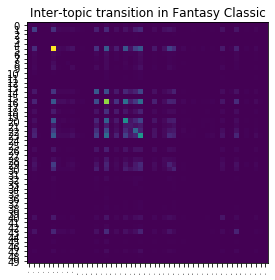

In [13]:

world_name = 'Fantasy Classic'
topic_transition_matrix = topic_transition_matrix_by_world_dict[world_name]

fig, ax = plt.subplots()
im = ax.imshow(topic_transition_matrix)

# We want to show all ticks...
num_topics = model.K
ax.set_xticks(np.arange(num_topics))
ax.set_yticks(np.arange(num_topics))

# # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", size=2,
             rotation_mode="anchor")


ax.set_title(f"Inter-topic transition in {world_name}")
fig.tight_layout()
plt.show()

In [18]:
# PLOT_SINGLE_CHAIN = True
def plot_single_chain(starting):
    starting_topic = topics_summarized[starting]
#     if starting_topic[:3]== 'unk':
#         continue
    print(f'Starting from topic {starting} {topics_summarized[starting]}: ')
    for idx, (world_name, _) in enumerate(world_counter.most_common()):
        if idx == 0:
            continue
        topic_transition_matrix = topic_transition_matrix_by_world_dict[world_name]

        # traverse through topic transition matrix
        track = []

        next = starting
        track.append(next)
        while len(track) < 2:
            all_candidates = topic_transition_matrix[next]
            desc_order = np.argsort(all_candidates)
            if next == desc_order[-1]:
                next = desc_order[-2]
            else:
                next = desc_order[-1] # -2 because the highest probability other than the diagonal
            track.append(next)

        track_str = []
        for i in track:
            track_str.append(topics_summarized[i])
        # print(f'In the world {world_name}, starting from {topics_summarized[starting]}:')
        print(f'[{world_name}]: ' + ' --> '.join(track_str))
        print()

        if idx >= 7:
            break
            

### Looking at topic transition

Since we have the topic transtiion matrices in different worlds, we can obersve plot transitions by investigating the question:
Given a particular topic, what is the next most probable topic that follows, in different worlds?
Here we start from the topic on education, or topic 49, as an example.

We can also look at more topics instead of the most probable one. For more details, please check world_vis.py

In [23]:
# Starting from topic 49
plot_single_chain(49)

Starting from topic 49 university, academy, faculty, school, veterinary, coaching, assistant, undergraduate, graduate, coach: 
[Fantasy Classic]: university, academy, faculty, school, veterinary, coaching, assistant, undergraduate, graduate, coach --> thine, fealty, uphold, valor, infantry, dominion, nobility, sword, valour, righteousness

[Urban Fantasy]: university, academy, faculty, school, veterinary, coaching, assistant, undergraduate, graduate, coach --> analyze, investigate, analyse, uncover, factual, thorough, forensic, investigative, investigating, investigation

[The Mysterious Island]: university, academy, faculty, school, veterinary, coaching, assistant, undergraduate, graduate, coach --> breathe, throaty, raspy, tremble, birdsong, voice, breathy, hoarse, stillness, guttural

[Space Adventure]: university, academy, faculty, school, veterinary, coaching, assistant, undergraduate, graduate, coach --> convoy, hiking, river, reconnaissance, roads, patrol, coastline, coast, airf